# Analysis

## Imports and setup

In [20]:
import os
import sys

# Add parent directory to system path
sys.path.append("../..")

import argparse
import pickle
from plotnine import *
import json
import pandas as pd
import os
import matplotlib.font_manager as fm
from matplotlib import rcParams
import itertools
import numpy as np
from scipy.stats import bootstrap, ttest_rel
from collections import defaultdict, Counter

from evaluate import data_generator
#from axbench import LatentStatsEvaluator #might need to edit this
from tqdm import tqdm

In [21]:
# set the theme
rcParams['font.family'] = "P052"
theme_set(theme_gray(base_family="P052") + theme(axis_text_x=element_text(angle=45, hjust=0.5)))

In [22]:
RESULTS_FOLDER = "/axbench/output_llama"
SUBFOLDERS = [
    "axbench/output_llama/layer_20_concise",
    # "prod_2b_l20_concept16k",
    # "prod_9b_l20_concept16k",
]
PLOT_FOLDER = "plot/"

METHODS = ["lsreft_addition"]
METHOD_MAP = {
    "LsReFT": "ReFT-r1-threshold",
    "LsReFT-gating": "ReFT-r1-gating",
    "LsReFT-base": "ReFT-r1",
    "LsReFT-clamping": "ReFT-r1-clamping",
    "SteeringVector": "SSV",
    "SparseLinearProbe": "Probe-SL",
    "DiffMean": "DiffMean",
    "PCA": "PCA",
    "LAT": "LAT",
    "GemmaScopeSAE": "SAE",
    "GemmaScopeSAEClamping": "SAE-c",
    "IntegratedGradients": "IG",
    "InputXGradients": "IxG",
    "LinearProbe": "Probe",
    "PromptSteering": "Prompt",
    "PromptDetection": "Prompt",
    "LoReFT": "LoReFT",
    "LoRA": "LoRA",
    "SFT": "SFT",
    "PromptAssistSteering": "Prompt Append",
}
MODEL_MAP = {
    "llama": "meta-llama/Llama-3.1-8B-Instruct",
}
LAYER_MAP = {
    "l19": "L19",
    "l25": "L25",
    "l24": "L24",
    "l20": "L20"
}
METRIC_MAP = {
    "macro_avg_accuracy": "Acc. (macro-avg)",
    "max_act": "Max Act.",
    "optimal_threshold": "Optimal Thresh.",
    "roc_auc": "ROC AUC",
    "max_lm_judge_rating": "Overall Score",
    "max_fluency_rating": "Fluency Score",
    "max_relevance_concept_rating": "Concept Score",
    "max_relevance_instruction_rating": "Instruct Score",
    "max_factor": "Steering Factor",
    "overall_accuracy": "Overall Accuracy",
    "f1": "F1",
    "precision": "Precision",
    "recall": "Recall",
}
FLOAT_METRICS = ['macro_avg_accuracy', 'max_act', 'optimal_threshold', 'roc_auc',
                 'max_lm_judge_rating', 'max_fluency_rating', 'max_relevance_concept_rating',
                 'max_relevance_instruction_rating', 'max_factor', 'overall_accuracy',
                 'f1', 'precision', 'recall', 'max_act_val', 'min_act_val']
INT_METRICS = ['concept_id']

def prettify_df(df):
    # rename columns
    for metric in FLOAT_METRICS:
        if metric in df.columns:
            df[metric] = df[metric].astype(float)
    for metric in INT_METRICS:
        if metric in df.columns:
            df[metric] = df[metric].astype(int)
    if "method" in df.columns:
        df["method"] = df["method"].apply(lambda x: METHOD_MAP.get(x, x))
        df = df.rename(columns={"method": "Method"})
    if "model" in df.columns:
        df["model"] = df["model"].apply(lambda x: MODEL_MAP.get(x, x))
    if "layer" in df.columns:
        df["layer"] = df["layer"].apply(lambda x: LAYER_MAP.get(x, x))
    df.columns = [METRIC_MAP[col] if col in METRIC_MAP else col for col in df.columns]
    return df


def mean_and_ci(group, n_bootstraps=1000, ci=0.95):
    values = group["values"].values
    # Compute mean
    mean_value = np.mean(values)
    if np.isnan(mean_value):
        print(values)
        print("bruh its nan")
    # Compute bootstrap CI
    result = bootstrap(
        data=(values,),
        statistic=np.mean,
        n_resamples=n_bootstraps,
        confidence_level=ci,
        method="percentile"
    )
    lower_ci, upper_ci = result.confidence_interval
    return pd.Series({"mean": mean_value, "lower_ci": lower_ci, "upper_ci": upper_ci})


def format_ci(mean, lower_ci, upper_ci, only_mean=False, percent=False):
    result = ""
    if only_mean:
        if percent:
            result = f"{mean:.1%}"
        else:
            result = f"{mean:.3f}"
    else:
        if percent:
            result = f"{mean:.1%}$^{{+{upper_ci-mean:.3f}}}_{{-{mean-lower_ci:.3f}}}$"
        else:
            result = f"{mean:.3f}$^{{+{upper_ci-mean:.3f}}}_{{-{mean-lower_ci:.3f}}}$"
    result = result.replace("%", "\\%")
    return result


def agg_first_non_nan(vals):
    for val in vals:
        if isinstance(val, list) or np.all(val):
            return val
    return np.nan


def split_metric(metric):
    splitted = metric.split(".")
    if len(splitted) > 4:
        splitted[3] = '.'.join(splitted[3:])
    return tuple(splitted[:4])

In [23]:
reload = True
import warnings
warnings.simplefilter('ignore')
# Add parent directory to system path
sys.path.append("../..")

In [24]:
# make plot folder if not exists
os.makedirs(PLOT_FOLDER, exist_ok=True)

all_dfs = []
if reload or not os.path.exists(f"{PLOT_FOLDER}/df.pkl"):
    for folder in SUBFOLDERS:
        print(folder)
        #if folder == "generate" or folder == "interfence" or folder == "lm_cache":
        #    continue
        #print(folder)
        #parts = folder.split("_")
        #assert len(parts) == 2
        #_, model, layer, split = parts
        model = "llama"
        layer = "l20"
        dfs = []
        for method in METHODS:
            method_folder = f"../../{folder}/{method}_20/evaluate" #might need to better edit this
            inference_folder = f"../../{folder}/{method}_20/inference" #might need to better edit this
            print(inference_folder)
            print(method, model, layer)
            if not os.path.exists(method_folder):
                continue
                
            # load latent eval
            megadict = defaultdict(dict)
            latent_eval = f"{method_folder}/latent.jsonl"
            if os.path.exists(latent_eval):
                print(f"Processing latent for {method}...")
                with open(latent_eval, "r") as f:
                    for line in f:
                        json_line = json.loads(line)
                        megadict[json_line['concept_id']]['latent'] = json_line['results']
            else:
                print(f"Skipping {method} because no latent.jsonl found")
            
            # load steering eval
            steering_eval = f"{method_folder}/steering.jsonl"
            if os.path.exists(steering_eval):
                print(f"Processing steering for {method}...")
                with open(steering_eval, "r") as f:
                    for line in f:
                        json_line = json.loads(line)
                        megadict[json_line['concept_id']]['steering'] = json_line['results']
            else:
                print(f"Skipping {method} because no steering.jsonl found")
            
            megalist = [{'concept_id': concept_id, **data} for concept_id, data in megadict.items()]
            df = pd.json_normalize(megalist)
            if "clamp" in method:
                df = df.rename(columns=lambda x: x.replace("GemmaScopeSAE", "GemmaScopeSAEClamping"))
                print(list(df.columns))
            dfs.append(df)
    
        # merge dfs based on concept_id column, pick the first one
        if len(dfs) == 0:
            continue
        df = pd.concat(dfs)
        # print(list(df.columns))
        # print("Duplicates:", len(df.duplicated(subset=["concept_id", "model", "layer"])))
        df = df.groupby("concept_id").first().reset_index()
        df["model"] = MODEL_MAP[model]
        df["layer"] = LAYER_MAP[layer]
        df["identifier"] = f"{model}, {layer}"
        all_dfs.append(df)

    # save df
    df = pd.concat(all_dfs)
    df.to_pickle(f"{PLOT_FOLDER}/df.pkl")
else:
    df = pd.read_pickle(f"{PLOT_FOLDER}/df.pkl")

axbench/output_llama/layer_20_concise
../../axbench/output_llama/layer_20_concise/lsreft_addition_20/inference
lsreft_addition llama l20
Processing latent for lsreft_addition...
Processing steering for lsreft_addition...


In [25]:
# make each method a row
id_vars = ['concept_id', 'model', 'layer', 'identifier']
value_vars = [col for col in df.columns if col not in id_vars]
melted_df = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name='metric', value_name='value')
melted_df["method"] = melted_df["metric"].apply(lambda x: METHOD_MAP.get(x.split(".")[2], x.split(".")[2]))
melted_df["metric"] = melted_df["metric"].apply(lambda x: ".".join(x.split(".")[3:]))
pivot_df = melted_df.pivot_table(index=id_vars + ['method'], columns='metric', values='value', aggfunc=agg_first_non_nan).reset_index()

## Plots

In [26]:
# make each method a row
id_vars = ['concept_id', 'model', 'layer', 'identifier']
value_vars = [col for col in df.columns if col not in id_vars]
melted_df = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name='metric', value_name='value')
melted_df["method"] = melted_df["metric"].apply(lambda x: METHOD_MAP.get(x.split(".")[2], x.split(".")[2]))
melted_df["metric"] = melted_df["metric"].apply(lambda x: ".".join(x.split(".")[3:]))
pivot_df = melted_df.pivot_table(index=id_vars + ['method'], columns='metric', values='value', aggfunc=agg_first_non_nan).reset_index()

# steering metrics
no_factor = ["Prompt", "LoRA"]
steering_metrics = ["lm_judge_rating", "fluency_ratings", "relevance_concept_ratings", "relevance_instruction_ratings"]
for metric in steering_metrics:
    pivot_df[metric] = pivot_df.apply(lambda row: np.mean(row[metric]) if isinstance(row[metric], list) and row["method"] in no_factor else row[metric], axis=1)

pivot_no_factor = pivot_df[pivot_df['method'].isin(no_factor)]
pivot_factor = pivot_df[~pivot_df['method'].isin(no_factor)]

def pick_max(pivot_df, factor = True):

    def harmonic_mean_columns(df, columns, new_column_name='lm_judge_rating_clamp'):
        def calculate_harmonic_means(row):
            # Get lists from the columns
            lists = [row[col] for col in columns]
            # Get the length of first list (assuming all lists have same length)
            n_elements = len(lists[0])
            # Calculate harmonic mean for each corresponding position
            result = []        
            for i in range(n_elements):
                values = [lst[i] for lst in lists]
                # If any value is 0, append 0, else calculate harmonic mean
                if 0 in values:
                    result.append(0)
                else:
                    result.append(len(values) / sum(1/v for v in values))          
            return result      
        
        df[new_column_name] = df.apply(calculate_harmonic_means, axis=1)
        return df

    def harmonic_mean_columns_v(df, columns, new_column_name='lm_judge_rating_clamp'):
        # Calculate harmonic mean: n / (1/x1 + 1/x2 + 1/x3)
        df[new_column_name] = len(columns) / (
            sum(1/df[col] for col in columns)
        )
        return df
    '''   
    if factor:
        print(pivot_df.iloc[8])
        pivot_df['relevance_concept_ratings_clamp'] = pivot_df['relevance_concept_ratings'].apply(lambda x: [(2-i)-(2-x[-1]) if (2-i) > (2-x[-1]) else 0 for i in x])
        pivot_df['relevance_concept_ratings'] = pivot_df['relevance_concept_ratings'].apply(lambda x: [2-i for i in x])
        pivot_df = harmonic_mean_columns(pivot_df, ['fluency_ratings', 'relevance_instruction_ratings', 'relevance_concept_ratings_clamp'])
    else:
        pivot_df['relevance_concept_ratings'] = pivot_df['relevance_concept_ratings'].apply(lambda x: (2-x))
        pivot_df['lm_judge_rating_clamp']= pivot_df["lm_judge_rating"]
    '''       
    pivot_df["max_lm_judge_rating"] = pivot_df["lm_judge_rating"].apply(lambda x: max(x) if isinstance(x, list) else x)
    pivot_df["max_lm_judge_rating_idx"] = pivot_df["lm_judge_rating"].apply(lambda x: np.argmax(x) if isinstance(x, list) else 0)
    pivot_df["max_fluency_rating"] = pivot_df.apply(lambda row: row["fluency_ratings"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["fluency_ratings"], list) else row["fluency_ratings"], axis=1)
    pivot_df["max_relevance_concept_rating"] = pivot_df.apply(lambda row: row["relevance_concept_ratings"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["relevance_concept_ratings"], list) else row["relevance_concept_ratings"], axis=1)
    pivot_df["max_relevance_instruction_rating"] = pivot_df.apply(lambda row: row["relevance_instruction_ratings"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["relevance_instruction_ratings"], list) else row["relevance_instruction_ratings"], axis=1)
    pivot_df["max_factor"] = pivot_df.apply(lambda row: row["factor"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["factor"], list) else row["factor"], axis=1)
    
    #need to better figure this out    
    pivot_df["max_lm_judge_rating"] = pivot_df.apply(lambda row: row["lm_judge_rating"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["lm_judge_rating"], list) else row["lm_judge_rating"], axis=1)
    return pivot_df

pivot_no_factor = pick_max(pivot_no_factor, factor = False)
pivot_factor = pick_max(pivot_factor)

pivot_df = pd.concat([pivot_factor, pivot_no_factor], ignore_index = True)
'''
for i in pivot_df[pivot_df['method'] == 'SAE']["relevance_concept_ratings"]:
    print(i)

print(list(pivot_df[pivot_df['method'] == 'SAE']["max_factor"]))
'''
d = pivot_df[pivot_df["method"] == "ReFT-r1"]['relevance_concept_ratings'].apply(lambda row: np.array(row).mean())
print(d.mean())

pivot_df = prettify_df(pivot_df)
no_factor = ["Prompt", "LoRA"]

0.62


In [30]:
print(df_subset)

     Method                             model layer  identifier  \
0   ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
1   ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
2   ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
3   ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
4   ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
5   ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
6   ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
7   ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
8   ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
9   ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
10  ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
11  ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
12  ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
13  ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l2

               Method                             model layer  identifier  \
0             ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
1   ReFT-r1-threshold  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
2             ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
3   ReFT-r1-threshold  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
4             ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
5   ReFT-r1-threshold  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
6             ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
7   ReFT-r1-threshold  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
8             ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
9   ReFT-r1-threshold  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
10            ReFT-r1  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   
11  ReFT-r1-threshold  meta-llama/Llama-3.1-8B-Instruct   L20  llama, l20   

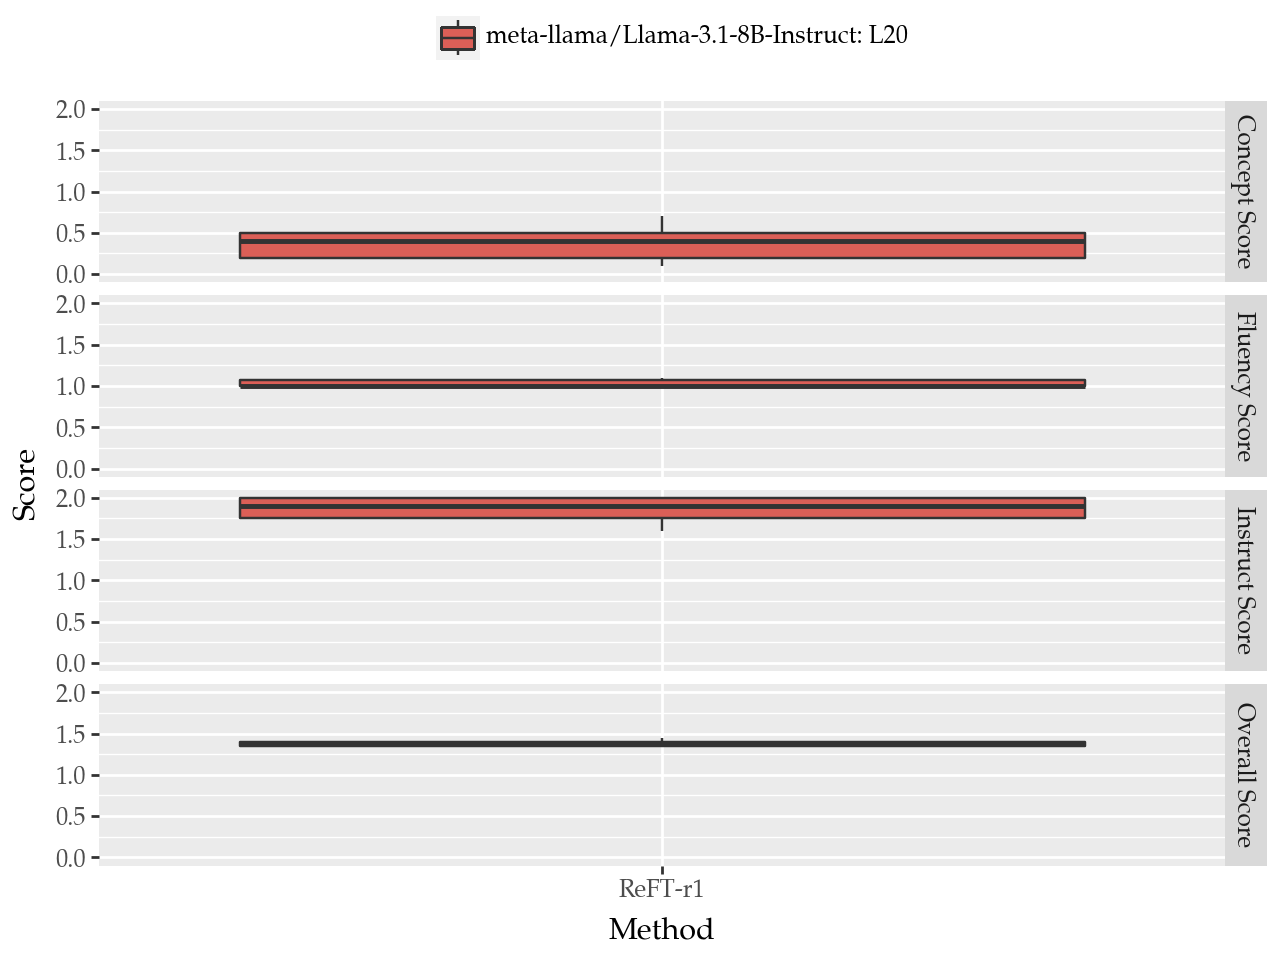

In [33]:
# plot each steering metric
df = pivot_df
steering_order = []
df_subset = df.copy()[["Method", "model", "layer", "identifier", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"]]
df_subset["Concept Score"] = df_subset["Concept Score"]
print(df_subset)
df_subset = df_subset.dropna(subset=["Concept Score", "Instruct Score", "Fluency Score", "Overall Score", "model", "layer"])
df_subset = df_subset.melt(id_vars=["Method", "model", "layer", "identifier"], value_vars=["Concept Score", "Instruct Score", "Fluency Score", "Overall Score"], var_name="metric", value_name="value")


#df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=[x for x in steering_order if x not in ignore])
plot = (
    ggplot(df_subset, aes(x="Method", y="value", fill='model + ": " + layer'))
    + facet_grid("metric~")
    # + facet_grid("model + layer ~")
    # + stat_summary(fun_data="mean_cl_boot", geom="bar", position="dodge")
    + geom_boxplot(outlier_shape="", position=position_dodge2(preserve="single"))
    # + geom_violin(position=position_dodge2())
    + labs(fill="", y="Score")
    + theme(legend_position="top", axis_text_x=element_text(angle=0, hjust=0.5))
    + scale_y_continuous(limits=[0, 2])
)
plot.show()
plot.save(f"{PLOT_FOLDER}/steering.pdf", width=8, height=5)

In [29]:
factor_df = df.copy()
factor_df = factor_df.dropna(subset=["factor"])
factor_df = factor_df[~factor_df["Method"].isin(no_factor)]

In [11]:
# plot factor vs score
factor_df = df.copy()
factor_df = factor_df.dropna(subset=["factor"])
factor_df_ = factor_df[factor_df["Method"].isin(no_factor)]
factor_df_['lm_judge_rating'] = factor_df_['lm_judge_rating'].apply(lambda x: [x for i in range(8)])
factor_df_['relevance_instruction_ratings'] = factor_df_['relevance_instruction_ratings'].apply(lambda x: [x for i in range(8)])
factor_df_['fluency_ratings'] = factor_df_['fluency_ratings'].apply(lambda x: [x for i in range(8)])
factor_df_['relevance_concept_ratings'] = factor_df_['relevance_concept_ratings'].apply(lambda x: [x for i in range(8)])

factor_df = factor_df[~factor_df["Method"].isin(no_factor)]

def get_factor_def(factor_df):
    factors = [val for val in factor_df["factor"]]
    def harmonic_mean(scores):
        # Return 0 if any score is 0 to maintain strict evaluation
        if 0 in scores:
            return 0
        else:
            return len(scores) / sum(1/s for s in scores)
        
    factor_dict = {
        "Steering Factor": [x for val in factor_df["factor"] for x in val],
        "Overall Score": [x for val in factor_df["lm_judge_rating"] for x in val],
        "Concept\nScore Reverse": [(2-x) for val in factor_df["relevance_concept_ratings"] for x in val],
        "Instruct Score": [x for val in factor_df["relevance_instruction_ratings"] for x in val],
        "Fluency Score": [x for val in factor_df["fluency_ratings"] for x in val],
        "Reverse Overall" : [x for val in factor_df["lm_judge_rating"] for x in val]}
    
    
    lens = [len(val) for val in factors]
    for col in id_vars + ["Method"]:
        factor_dict[col] = [val for i, val in enumerate(factor_df[col]) for _ in range(lens[i])]
    factor_df_og = pd.DataFrame(factor_dict)
    #factor_df_og["Method"] = pd.Categorical(factor_df_og["Method"], categories=[x for x in steering_order if (x not in no_factor) and (x not in ignore)])
    factor_df = factor_df_og.melt(id_vars=id_vars + ["Method", "Steering Factor"], value_vars=["Reverse Overall", "Concept\nScore Reverse", "Instruct Score", "Fluency Score"], var_name="metric", value_name="value")
    return factor_df

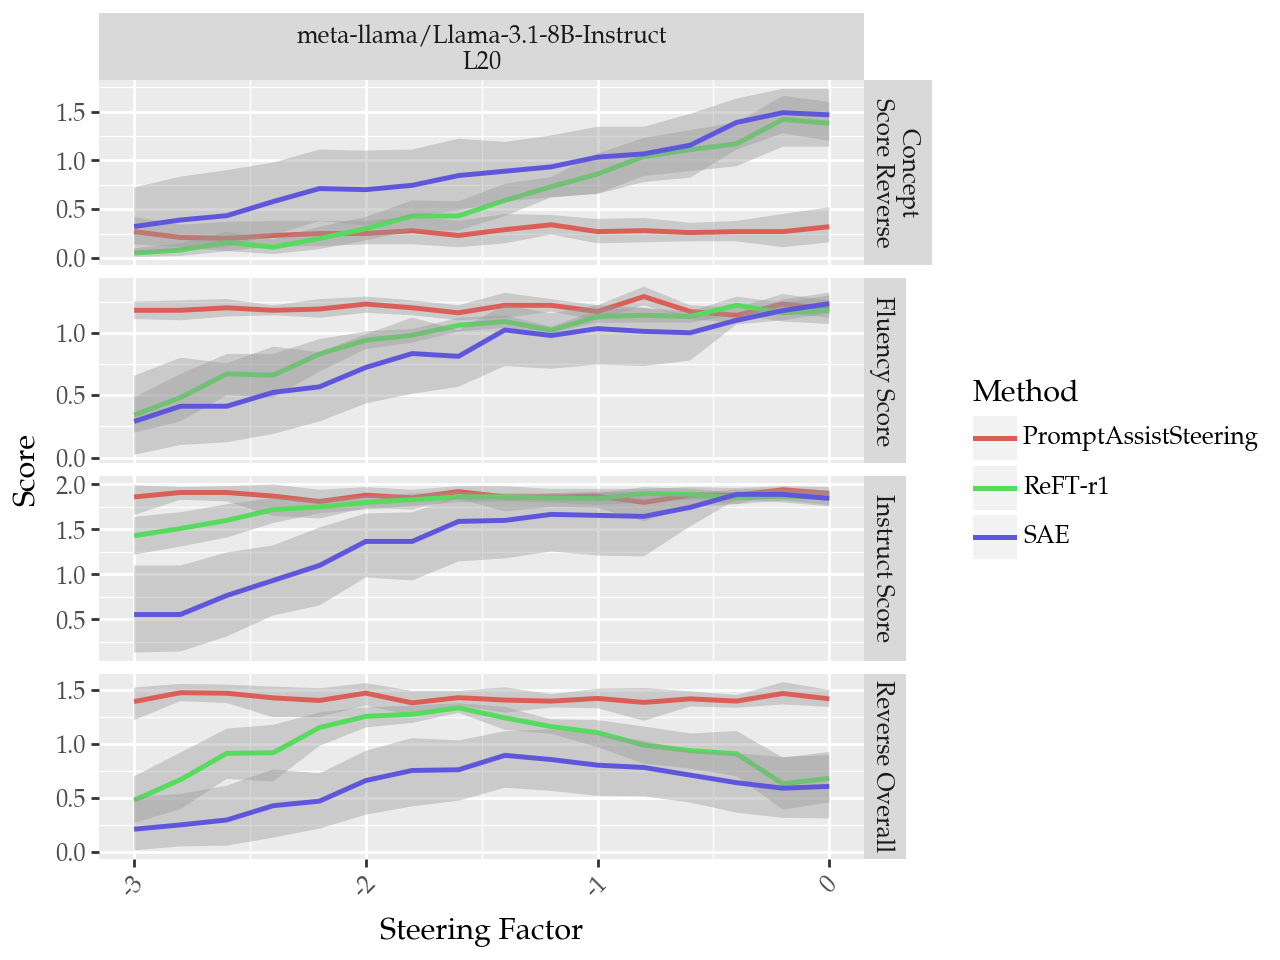

In [22]:
plot = (
    ggplot(get_factor_def(factor_df), aes(x="Steering Factor", y="value", color="Method"))
    + stat_summary(fun_data="mean_cl_boot", geom="smooth")
    #+ scale_x_log10()
    + facet_grid("metric~model + layer", scales="free_y")
    + labs(x="Steering Factor", y="Score")
)
plot.show()
plot.save(f"{PLOT_FOLDER}/steering_factor.pdf", width=8, height=6)